In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
temp = pd.read_csv('temp_by_date.csv')
temp.columns = temp.columns.str.strip()
temp.head()

,STN---,WBAN,YEARMODA,TEMP,,DEWP,.1,SLP,.2,STP,...,WDSP,.5,MXSPD,GUST,MAX,MIN,PRCP,SNDP,FRSHTT,Unnamed: 22
0,997338,99999,20050322,35.0,12,9999.9,0,9999.9,0,9999.9,...,16.9,12,23.9,999.9,35.4*,34.3*,0.00I,999.9,0,NaN
1,997338,99999,20050323,35.1,24,9999.9,0,9999.9,0,9999.9,...,19.0,24,23.9,999.9,37.2*,32.5*,0.00I,999.9,0,NaN
2,997338,99999,20050324,34.0,24,9999.9,0,9999.9,0,9999.9,...,7.9,24,16.9,999.9,36.3*,31.3*,0.00I,999.9,0,NaN
3,997338,99999,20050325,34.6,24,9999.9,0,9999.9,0,9999.9,...,11.1,24,18.1,999.9,36.7*,32.0*,0.00I,999.9,0,NaN
4,997338,99999,20050326,34.2,21,9999.9,0,9999.9,0,9999.9,...,9.0,21,15.9,999.9,35.1*,33.3*,0.00I,999.9,0,NaN


In [4]:
temp = temp[['YEARMODA', 'TEMP', 'PRCP']]
temp['YEAR'] = temp['YEARMODA'].astype(str).map(lambda x: x[:4])
temp['MONTH'] = temp['YEARMODA'].astype(str).map(lambda x: x[4:6])
temp['DAY'] = temp['YEARMODA'].astype(str).map(lambda x: x[6:])
temp = temp.drop('YEARMODA', axis=1)
temp = temp.set_index(['YEAR', 'MONTH', 'DAY'])

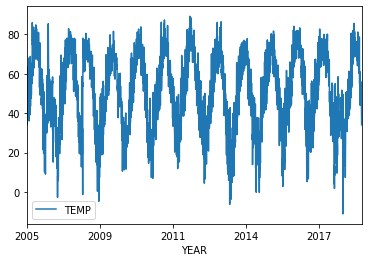

In [5]:
temp.reset_index().set_index('YEAR')[['TEMP']].plot()

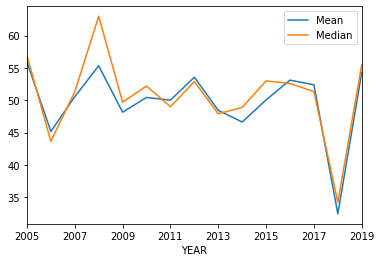

In [12]:
mean_temp_by_year = temp[['TEMP']].groupby('YEAR').mean()
median_temp_by_year = temp[['TEMP']].groupby('YEAR').median()

ax = mean_temp_by_year.plot()
median_temp_by_year.plot(ax=ax)
ax.legend(['Mean', 'Median'])

In [46]:
import pyarrow.parquet as pq
path = 'extended_dataset.parquet'
df = pd.read_parquet(path)
df.head(2)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,...,Re-inspection,Community,Neighborhood,Ward,Precinct,Violation IDs,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity
0,2320519,SALAM RESTAURANT,SALAM RESTAURANT,2002822,Restaurant,High,4634-4636 N KEDZIE AVE,60625,2019-10-25,Complaint,...,True,ALBANY PARK,"NORTH PARK,ALBANY PARK",33,27,[None],0,0,0,0
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,...,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38,"[3, 5, 25, 50, 53, 53, 56, 58]",8,2,1,5


Text(0.5, 1.0, 'Number of inspections by year')

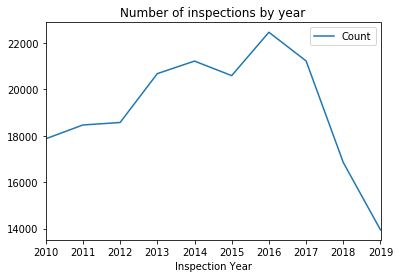

In [47]:
nb_inspections_by_year = df[['Inspection Date', 'Inspection ID']].copy()
nb_inspections_by_year['Inspection Date'] = nb_inspections_by_year['Inspection Date'].apply(lambda x: x.year).astype(str)
nb_inspections_by_year.rename(columns={'Inspection Date' : 'Inspection Year'}, inplace=True)
nb_inspections_by_year = nb_inspections_by_year.groupby('Inspection Year').count().rename(columns={'Inspection ID' : 'Count'})
nb_inspections_by_year.plot()
plt.title("Number of inspections by year")

In [48]:
df_joined_inspections = nb_inspections_by_year.rename(index={'Inspection Year' : 'YEAR'}).join(mean_temp_by_year)
df_joined_inspections

,Count,TEMP
Inspection Year,,
2010,17866,50.431549
2011,18461,50.015746
2012,18568,53.566942
2013,20672,48.443802
2014,21213,46.631129
2015,20587,50.051695
2016,22455,53.117080
2017,21219,52.385359
2018,16844,32.410435


In [49]:
df_joined_inspections.corr()

,Count,TEMP
Count,1.000000,0.149667
TEMP,0.149667,1.000000


Text(0.5, 1.0, 'Number of failed inspections by year')

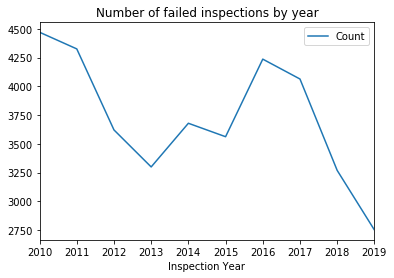

In [50]:
nb_fails_by_year= df[df['Results'] == 'Fail'].copy()
nb_fails_by_year = nb_fails_by_year[['Inspection Date', 'Inspection ID']]
nb_fails_by_year['Inspection Date'] = nb_fails_by_year['Inspection Date'].apply(lambda x: x.year).astype(str)
nb_fails_by_year.rename(columns={'Inspection Date' : 'Inspection Year'}, inplace=True)
nb_fails_by_year = nb_fails_by_year.groupby('Inspection Year').count().rename(columns={'Inspection ID' : 'Count'})
nb_fails_by_year.plot()
plt.title("Number of failed inspections by year")

In [51]:
df_joined_fails = nb_fails_by_year.rename(index={'Inspection Year' : 'YEAR'}).join(mean_temp_by_year)
df_joined_fails

,Count,TEMP
Inspection Year,,
2010,4471,50.431549
2011,4326,50.015746
2012,3621,53.566942
2013,3299,48.443802
2014,3679,46.631129
2015,3562,50.051695
2016,4237,53.117080
2017,4064,52.385359
2018,3269,32.410435


In [52]:
df_joined_fails.corr()

,Count,TEMP
Count,1.00000,0.22617
TEMP,0.22617,1.00000


Text(0.5, 1.0, 'Number of violations by year')

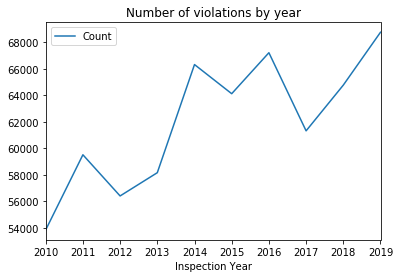

In [53]:
nb_violations_by_year = df[['Inspection Date', 'Nb Violations']].copy()
nb_violations_by_year['Inspection Date'] = nb_violations_by_year['Inspection Date'].apply(lambda x: x.year).astype(str)
nb_violations_by_year.rename(columns={'Inspection Date' : 'Inspection Year'}, inplace=True)
nb_violations_by_year = nb_violations_by_year.groupby('Inspection Year').sum().rename(columns={'Nb Violations' : 'Count'})
nb_violations_by_year.plot()
plt.title("Number of violations by year")

In [54]:
df_joined_violations = nb_violations_by_year.rename(index={'Inspection Year' : 'YEAR'}).join(mean_temp_by_year)
df_joined_violations

,Count,TEMP
Inspection Year,,
2010,53850,50.431549
2011,59517,50.015746
2012,56412,53.566942
2013,58166,48.443802
2014,66321,46.631129
2015,64123,50.051695
2016,67214,53.117080
2017,61322,52.385359
2018,64771,32.410435


In [55]:
df_joined_violations.corr()

,Count,TEMP
Count,1.000000,-0.129072
TEMP,-0.129072,1.000000


Nothing interesting...